In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from datetime import date

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# Scipy for statistics
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

%matplotlib inline

## 1. Populate Dataframes

In [6]:
# read from csv files
 
WF_stock = pd.read_csv(r'./Stock_Price/wFC_limited.csv',encoding='latin-1')
SAP_stock = pd.read_csv(r'./Stock_Price/SAP_limited.csv',encoding='latin-1')

In [7]:
WF_stock['Date'] = WF_stock['Date'].astype('datetime64[ns]') 
SAP_stock['Date'] = SAP_stock['Date'].astype('datetime64[ns]') 

In [8]:
WF_stock.reset_index(drop=True)
WF_stock.set_index('Date')

#WF_stock.ffill(axis = 0)
# https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe

# add Close price difference column
WF_stock['Close_diff']= WF_stock['Close'].diff()
# set first row to 0
WF_stock.Close_diff.iloc[0]  = 0

WF_stock.head() 

C:\Users\yulmee\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Open,High,Low,Close,Adj Close,Volume,Close_diff
0,2019-09-25,48.730000,49.540001,48.650002,49.259998,48.793034,21313100,0.000000
1,2019-09-26,49.250000,49.369999,48.820000,48.869999,48.406731,19984000,-0.389999
2,2019-09-27,50.400002,51.410000,50.250000,50.709999,50.229290,59467400,1.840000
3,2019-09-30,50.770000,50.849998,50.060001,50.439999,49.961849,26897100,-0.270000
4,2019-10-01,50.650002,50.779999,49.000000,49.060001,48.594933,27249300,-1.379998


In [9]:
SAP_stock.reset_index(drop=True)
SAP_stock.set_index('Date')

# add Close price difference column
SAP_stock['Close_diff']= SAP_stock['Close'].diff()
# set first row to 0
SAP_stock.Close_diff.iloc[0]  = 0

SAP_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_diff
0,2019-10-09,115.849998,116.739998,115.580002,116.050003,116.050003,1061600,0.000000
1,2019-10-10,114.959999,116.160004,114.559998,115.250000,115.250000,1062100,-0.800003
2,2019-10-11,125.720001,127.900002,125.470001,126.199997,126.199997,2234300,10.949997
3,2019-10-14,125.940002,126.559998,125.739998,126.050003,126.050003,877700,-0.149994
4,2019-10-15,125.830002,127.889999,125.470001,127.180000,127.180000,830900,1.129997


## 2. WF

C:\Users\yulmee\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


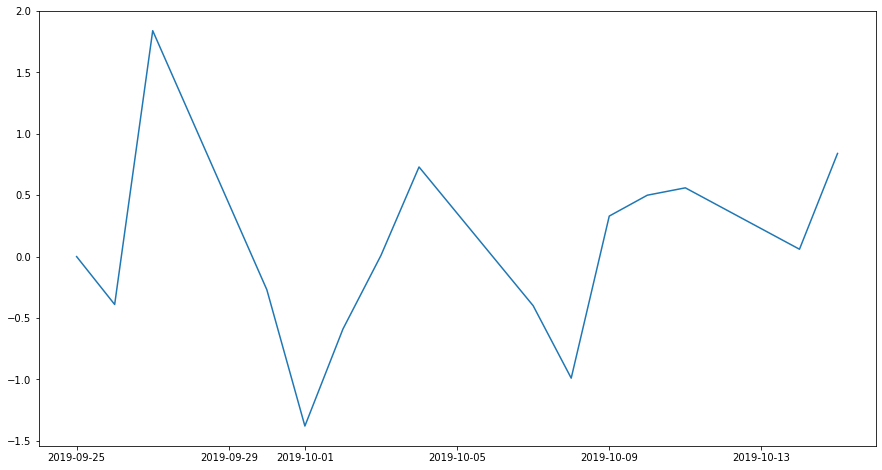

In [10]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes()
ax.plot(WF_stock.Date, WF_stock.Close_diff);

### 2.1. simple linear regression to show trend.

Intercept from library: -0.06913953845254772
Slope from library: 0.016129026297335248


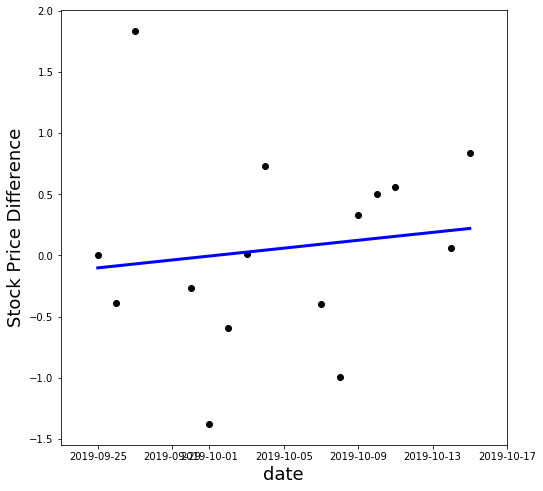

In [12]:
xlim_max = WF_stock.Date.max() + timedelta(days=2)
xlim_min = WF_stock.Date.min() - timedelta(days=2)

WF_stock['Intercept'] = 1
# Create the features and response
X = WF_stock.loc[:, ['Intercept', 'Date']]
y = WF_stock.loc[:, 'Close_diff']

wf_announced_date = datetime(2019, 9, 27,0,0,0)  
X['Timestamp'] = X.apply(lambda row: (row.Date - wf_announced_date).days, axis = 1) 

linear_regression = LinearRegression()
linear_regression.fit(np.array(X.Timestamp).reshape(-1,1),y)
y_pred = linear_regression.predict(X.Timestamp.values.astype(float).reshape(-1,1))
# df.time.values.astype(float).reshape(-1, 1)
print('Intercept from library:', linear_regression.intercept_)
print('Slope from library:', linear_regression.coef_[0])
wf_tb_intercept = linear_regression.intercept_
wf_tb_slope =  linear_regression.coef_[0]
# Notes: see 
# 1. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
# 2. https://stackoverflow.com/questions/54352621/sklearn-linear-regression-with-date-data

plt.figure(figsize=(8, 8)) 
plt.scatter(X.Date, y,  color='black')
plt.plot(X.Date, y_pred, color='blue', linewidth=3)
plt.xlabel('date', size = 18); plt.ylabel('Stock Price Difference', size = 18); 
plt.xlim([xlim_min, xlim_max]) 

plt.show()

## 3. SAP

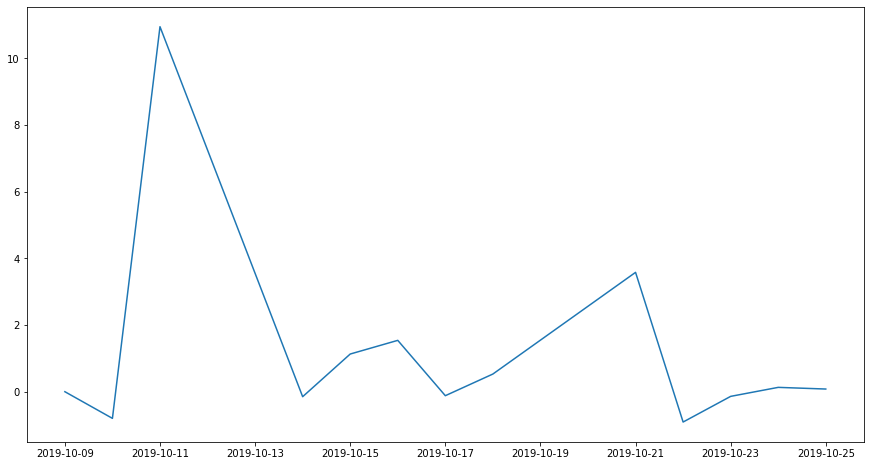

In [13]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes()
ax.plot(SAP_stock.Date, SAP_stock.Close_diff);

### 3.1. simple linear regression to show trend.

Intercept from library: 2.404064747928479
Slope from library: -0.16245104971652888


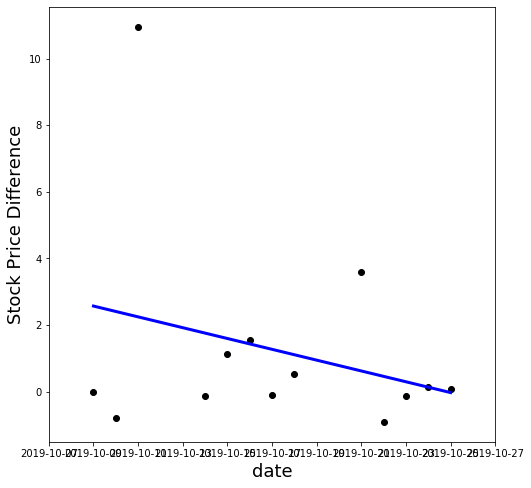

In [14]:
xlim_max = SAP_stock.Date.max() + timedelta(days=2)
xlim_min = SAP_stock.Date.min() - timedelta(days=2)

SAP_stock['Intercept'] = 1
# Create the features and response
X = SAP_stock.loc[:, ['Intercept', 'Date']]
y = SAP_stock.loc[:, 'Close_diff']

sap_announced_date = datetime(2019, 10, 10,0,0,0)  
X['Timestamp'] = X.apply(lambda row: (row.Date - sap_announced_date).days, axis = 1) 

linear_regression = LinearRegression()
linear_regression.fit(np.array(X.Timestamp).reshape(-1,1),y)
y_pred = linear_regression.predict(X.Timestamp.values.astype(float).reshape(-1,1))
# df.time.values.astype(float).reshape(-1, 1)
print('Intercept from library:', linear_regression.intercept_)
print('Slope from library:', linear_regression.coef_[0])
wf_tb_intercept = linear_regression.intercept_
wf_tb_slope =  linear_regression.coef_[0]
# Notes: see 
# 1. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
# 2. https://stackoverflow.com/questions/54352621/sklearn-linear-regression-with-date-data

plt.figure(figsize=(8, 8)) 
plt.scatter(X.Date, y,  color='black')
plt.plot(X.Date, y_pred, color='blue', linewidth=3)
plt.xlabel('date', size = 18); plt.ylabel('Stock Price Difference', size = 18); 
plt.xlim([xlim_min, xlim_max]) 

plt.show()